# Plot data

In [19]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import models
from omegaconf import OmegaConf

In [2]:
# !pip install omegaconf

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import torch

In [7]:
def plot_time_series(path):
    wav = np.load(path)
    plt.figure(figsize=(10,3))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel(u"Voltage (\u03bcV)", fontsize=25)
    plt.xticks(np.arange(0,len(wav)+1, 2048), [x/2048 for x in np.arange(0,len(wav)+1, 2048)])
    plt.xlabel("Time (s)", fontsize=25)
    plt.plot(wav)

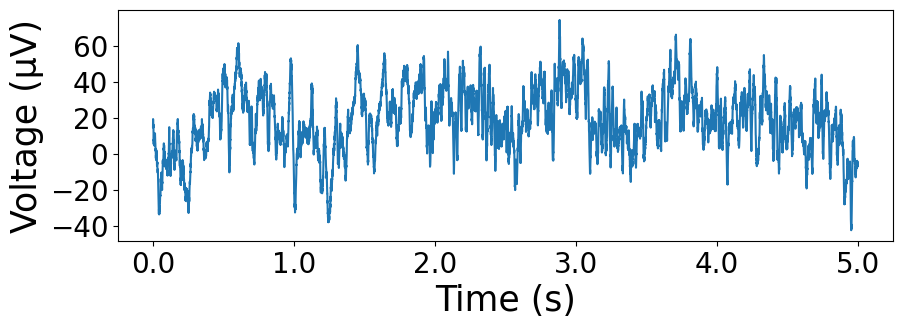

In [8]:
plot_time_series("example_wav_1.npy")

In [9]:
def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)
   
    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]

    Zxx = np.abs(Zxx)
    clip = 5 #To handle boundary effects
    if normalizing=="zscore":
        Zxx = Zxx[:,clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing=="baselined":
        Zxx = baseline(Zxx[:,clip:-clip])
        t = t[clip:-clip]
    elif normalizing=="db":
        Zxx = np.log2(Zxx[:,clip:-clip])
        t = t[clip:-clip]

    if np.isnan(Zxx).any():
        import pdb; pdb.set_trace()

    return f, t, Zxx

def plot_stft(path):
    wav = np.load(path)
    f,t,linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
    plt.figure(figsize=(15,3))
    f[-1]=200
    g1 = plt.pcolormesh(t,f,linear, shading="gouraud", vmin=-3, vmax=5)

    cbar = plt.colorbar(g1)
    tick_font_size = 15
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
    plt.xticks(fontsize=20)
    plt.ylabel("")
    plt.yticks(fontsize=20)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Frequency (Hz)", fontsize=20)

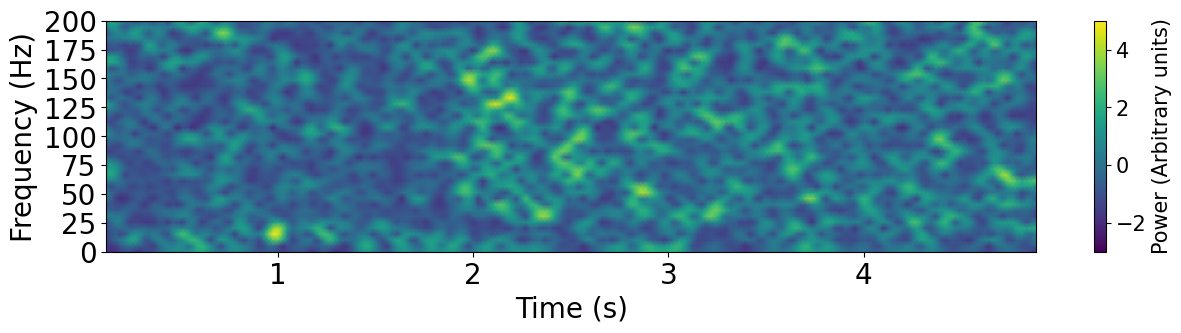

In [10]:
plot_stft("example_wav_1.npy")

# Load model

In [21]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path)
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream

def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)

In [25]:
ckpt_path = "../pretrained_weights/stft_large_pretrained.pth"
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})
model = build_model(cfg)
model.to('cuda')
init_state = torch.load(ckpt_path)
load_model_weights(model, init_state['model'], False)

/var/folders/fs/x24thkh503g0kjzhsc374x_c0000gn/T/ipykernel_15006/2987780488.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  init_state = torch.load(ckpt_path)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# Get output

In [10]:
    wav = np.load(path)

f,t,linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1,2).to('cuda')
mask = torch.zeros((inputs.shape[:2])).bool().to('cuda')
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)

NameError: name 'wav' is not defined

In [ ]:
inputs.shape, out.shape